In [1]:
import pickle

with open('../data/processed/weatherAU-processed.pkl', 'rb') as f:
    df = pickle.load(f)

df.columns.to_numpy()

array(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RISK_MM', 'RainTomorrow'], dtype=object)

In [2]:
# Set features and target data
features = df[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 
               'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 
               'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
               'Humidity3pm', 'Pressure9am', 'Pressure3pm',  'Cloud9am', 
               'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']]
target = df['RainTomorrow']

# Split dataset into train set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=28732)

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [3]:
import matplotlib.pyplot as plt

def plot_roc_curve(fper, tper):
    plt.figure(figsize=(6,4))
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0,1], [0,1], color='darkblue', linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristics (ROC) curve')
    plt.legend()
    plt.show()

In [4]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report, ConfusionMatrixDisplay

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t_0 = time.time()
    if verbose == False:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t_0
    
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen Kappa = {}".format(coh_kap))
    print(classification_report(y_test, y_pred, digits=5))
    
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    
    plot_roc_curve(fper, tper)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues, normalize='all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.787639444775611
ROC Area under Curve = 0.7676845441484516
Cohen Kappa = 0.5450036632129613
              precision    recall  f1-score   support

           0    0.80743   0.85716   0.83155     28724
           1    0.75102   0.67821   0.71276     18248

    accuracy                        0.78764     46972
   macro avg    0.77922   0.76768   0.77216     46972
weighted avg    0.78551   0.78764   0.78540     46972



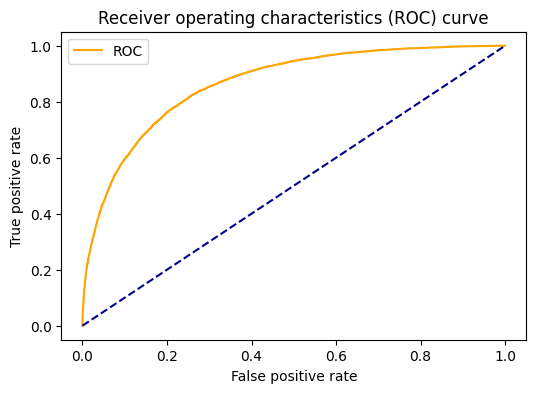

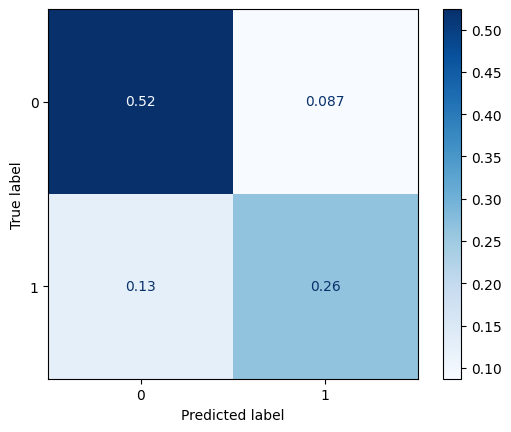

In [5]:
# Training rainfall prediction with different models

# Logistic Regression
from sklearn.linear_model import LogisticRegression
params_lr = {'penalty': 'l1', 'solver': 'liblinear'}
model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

Accuracy = 0.8633015413437792
ROC Area under Curve = 0.8631563746175868
Cohen Kappa = 0.7162702937664498
              precision    recall  f1-score   support

           0    0.90817   0.86381   0.88543     28724
           1    0.80093   0.86251   0.83058     18248

    accuracy                        0.86330     46972
   macro avg    0.85455   0.86316   0.85800     46972
weighted avg    0.86650   0.86330   0.86412     46972



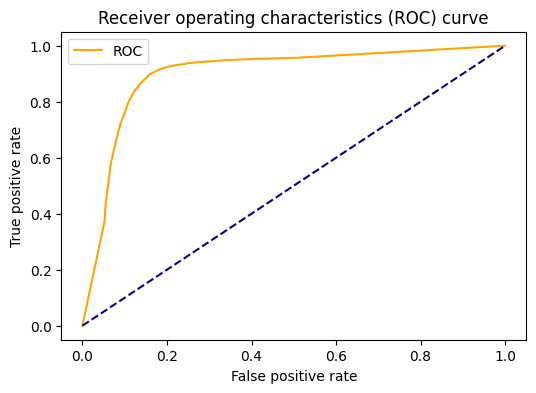

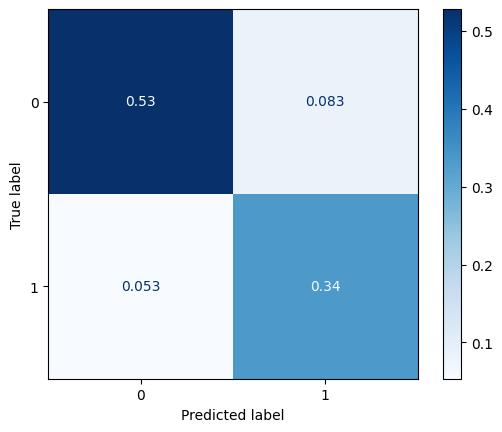

In [6]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth': 16, 'max_features': 'sqrt'}
model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy = 0.8849527378012433
ROC Area under Curve = 0.879190473594373
Cohen Kappa = 0.7579870612840436
              precision    recall  f1-score   support

           0    0.90667   0.90503   0.90585     28724
           1    0.85093   0.85335   0.85214     18248

    accuracy                        0.88495     46972
   macro avg    0.87880   0.87919   0.87899     46972
weighted avg    0.88501   0.88495   0.88498     46972



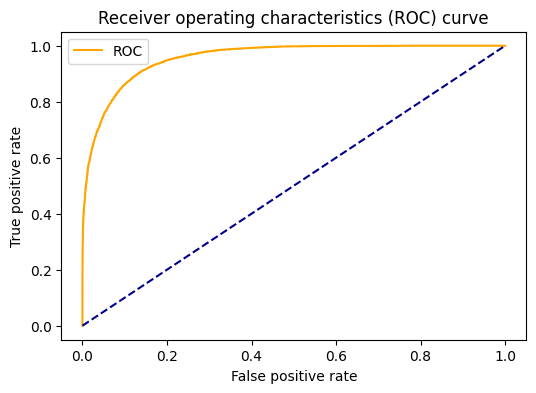

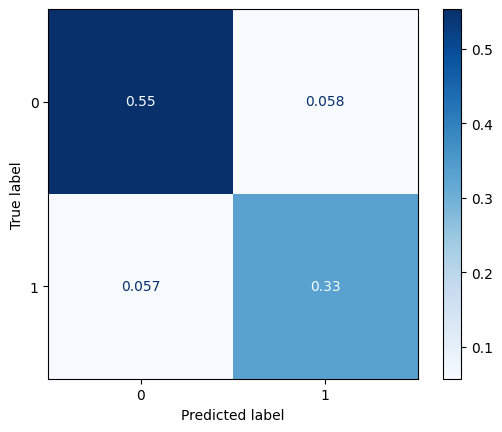

In [7]:
# Neural Network
from sklearn.neural_network import MLPClassifier
params_nn = {
    'hidden_layer_sizes': (30,30,30),
    'activation': 'logistic',
    'solver': 'lbfgs',
    'max_iter': 500
}
model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

Accuracy = 0.9289576769139062
ROC Area under Curve = 0.9287616131174738
Cohen Kappa = 0.8515240538540898
              precision    recall  f1-score   support

           0    0.95303   0.92964   0.94119     28724
           1    0.89337   0.92788   0.91030     18248

    accuracy                        0.92896     46972
   macro avg    0.92320   0.92876   0.92574     46972
weighted avg    0.92985   0.92896   0.92919     46972



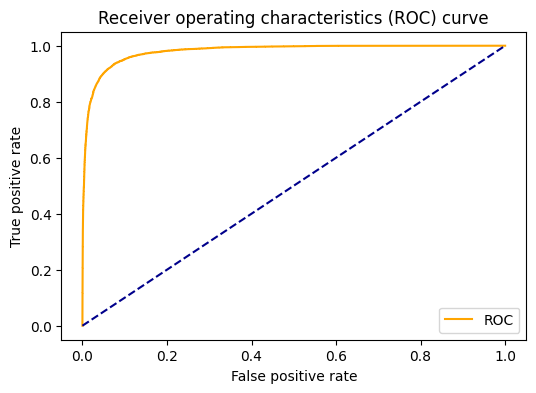

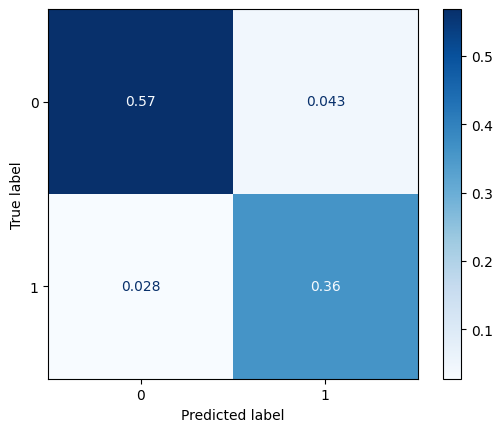

In [15]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
params_rf = {
    'max_depth': 16,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 512
}
model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

Accuracy = 0.9497998807800392
ROC Area under Curve = 0.9538676373688398
Cohen Kappa = 0.8957404940951303
              precision    recall  f1-score   support

           0    0.98141   0.93563   0.95797     28724
           1    0.90561   0.97211   0.93768     18248

    accuracy                        0.94980     46972
   macro avg    0.94351   0.95387   0.94783     46972
weighted avg    0.95196   0.94980   0.95009     46972



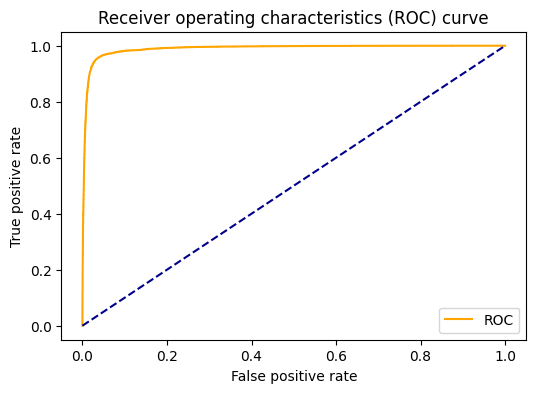

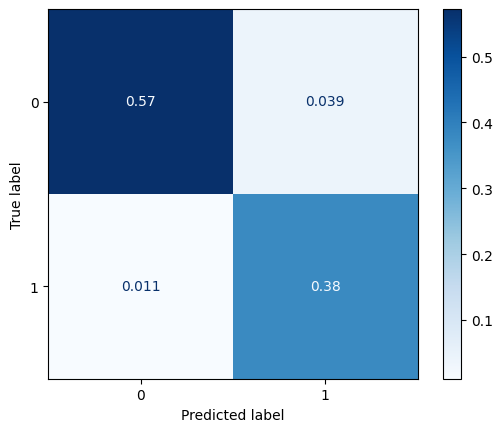

In [12]:
# XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

params_xgb = {
    'n_estimators': 500,
    'max_depth': 16
}
model_xgb = XGBClassifier(**params_xgb)

model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

In [16]:
# XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

params_xgb = {
    'n_estimators': 500,
    'max_depth': 16
}
model_xgb = XGBClassifier(**params_xgb)

params_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5]
}

grid_search = GridSearchCV(model_xgb, params_grid, cv=5,scoring='accuracy')

grid_search.fit(X_train, y_train)
print('Best hyperparam: ', grid_search.best_params_)

best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(grid_search, X_train, y_train, X_test, y_test)

Best hyperparam:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}


Accuracy  Time taken
0.787639  1.786027      1
0.863302  0.303983      1
0.884953  243.781859    1
0.928958  23.840417     1
0.949800  3.008939      1
Name: count, dtype: int64


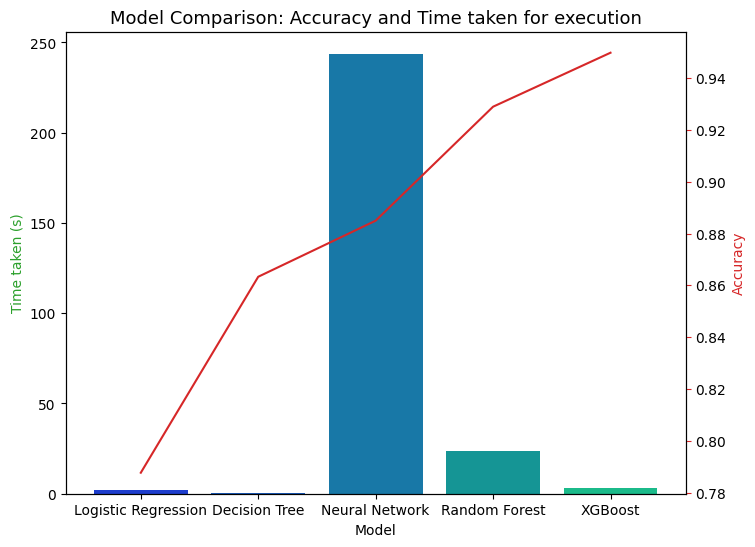

In [19]:
import pandas as pd
import seaborn as sns

accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
model_data = pd.DataFrame(model_data)

score = model_data[['Accuracy', 'Time taken']].value_counts()
print(score)

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=10)
ax1.set_ylabel('Time taken (s)', fontsize=10, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = model_data, hue='Model', legend=False, palette='winter')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=10, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = model_data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

ROC_AUC   Cohen_Kappa
0.767685  0.545004       1
0.863156  0.716270       1
0.879190  0.757987       1
0.928762  0.851524       1
0.953868  0.895740       1
Name: count, dtype: int64


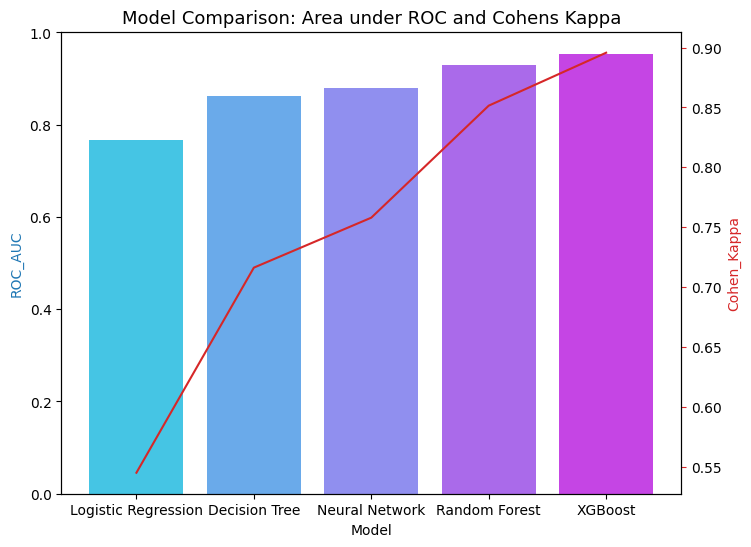

In [20]:
score = model_data[['ROC_AUC', 'Cohen_Kappa']].value_counts()
print(score)

fig, ax3 = plt.subplots(figsize=(8,6))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=10)
ax3.set_ylabel('ROC_AUC', fontsize=10, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = model_data, hue='Model', legend=False, palette='cool')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=10, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = model_data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()